### Convolutional Autoencoders - Image Denoising

#### References
- [Building autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Convolutional autoencoder for image denoising](https://keras.io/examples/vision/autoencoder/)
- [TF Intro to autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)

<a href="https://colab.research.google.com/github/paulaceccon/deep-learning-studies/blob/main/notebooks/generative_models/autoencoders/cnn_autoencoder.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

%load_ext tensorboard

![alt-text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### Load the dataset

In [2]:
def preprocess(data: np.array) -> np.ndarray:
    data = data.astype("float32") / 255.0
    data = np.reshape(data, (len(data), 28, 28, 1))
    return data

In [3]:
def noise(data: np.ndarray) -> np.ndarray:
    noise_factor = 0.4
    noisy_data = data + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=data.shape
    )

    return np.clip(noisy_data, 0.0, 1.0)

In [4]:
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)
noisy_train_data = noise(x_train)
noisy_test_data = noise(x_test)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Visualization

In [5]:
def plot_figures(original: np.ndarray, decoded: np.ndarray) -> None:
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [6]:
def plot_encoded(encoded: np.ndarray) -> None:
    n = 10
    plt.figure(figsize=(20, 8))
    for i in range(1, n + 1):
        ax = plt.subplot(1, n, i)
        plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Model

In [8]:
class Encoder(Model):
    def __init__(self):
        super().__init__(name="encoder")
        self.encoder = Sequential(
            [
                Input(shape=(28, 28, 1)),
                Conv2D(16, (3, 3), activation="relu", padding="same"),
                MaxPooling2D((2, 2), padding="same"),
                Conv2D(8, (3, 3), activation="relu", padding="same"),
                MaxPooling2D((2, 2), padding="same"),
                Conv2D(8, (3, 3), activation="relu", padding="same"),
                MaxPooling2D((2, 2), padding="same"),
            ]
        )

    def call(self, inputs):
        return self.encoder(inputs)

In [9]:
class Decoder(Model):
    def __init__(self):
        super().__init__(name="decoder")
        self.decoder = Sequential(
            [
                Conv2D(8, (3, 3), activation="relu", padding="same"),
                UpSampling2D((2, 2)),
                Conv2D(8, (3, 3), activation="relu", padding="same"),
                UpSampling2D((2, 2)),
                Conv2D(16, (3, 3), activation="relu"),
                UpSampling2D((2, 2)),
                Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
            ]
        )

    def call(self, inputs):
        return self.decoder(inputs)

In [10]:
class Autoencoder(Model):
    """Implements a basic convolutional autoencoder."""

    def __init__(self, name: str = "autoencoder"):
        super().__init__(name=name)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs: np.ndarray):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

### Training

In [11]:
def train_model(train_data: np.ndarray, test_data: np.ndarray) -> Autoencoder:
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    autoencoder = Autoencoder()
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    autoencoder.fit(
        train_data,
        train_data,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(test_data, test_data),
        verbose=0,
        callbacks=[EarlyStopping(patience=5), tensorboard_callback],
    )
    return autoencoder

In [12]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7472), started 2:42:14 ago. (Use '!kill 7472' to kill it.)

In [13]:
autoencoder = train_model(noisy_train_data, noisy_test_data)

2022-03-02 18:46:42.185999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1904      
                                                                 
 decoder (Decoder)           multiple                  2481      
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


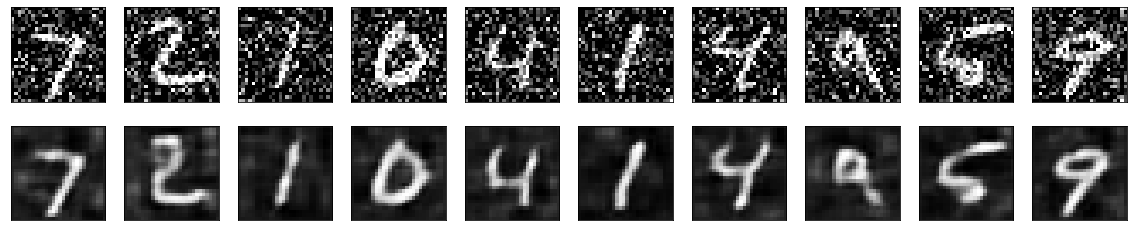

In [15]:
decoded_imgs = autoencoder.predict(noisy_test_data)
plot_figures(noisy_test_data, decoded_imgs)

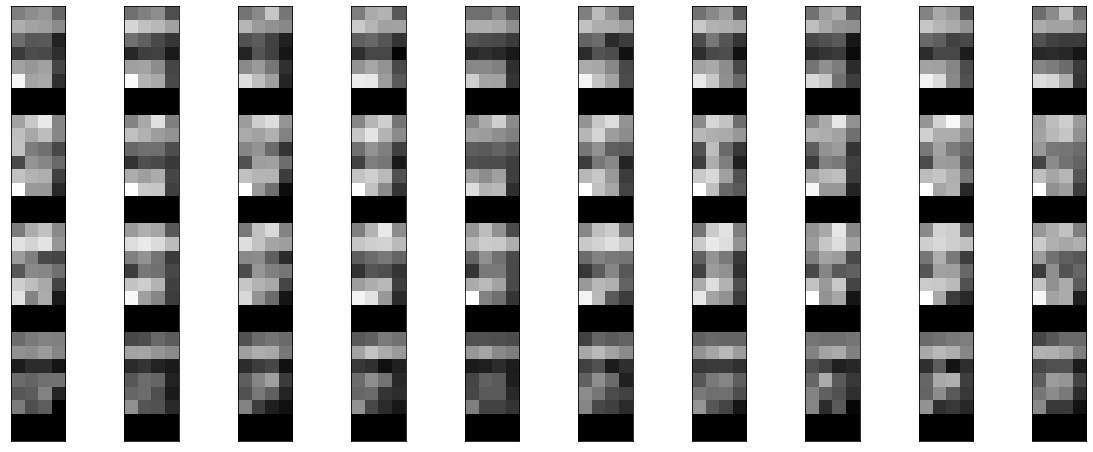

In [18]:
encoded_imgs = autoencoder.encoder.predict(noisy_test_data)
plot_encoded(encoded_imgs)